In [ ]:
!unzip Data-Images.zip

unzip:  cannot find or open Data-Images.zip, Data-Images.zip.zip or Data-Images.zip.ZIP.


# Imports

In [ ]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2

import json

In [ ]:
pwd

'/content'

# Load the `.json` file containing the download paths of the images

In [ ]:
# read the data
data = pd.read_json('Indian_Number_plates.json',lines=True)
pd.set_option('display.max_colwidth', -1)
# delete the extras column
del data['extras']
# check the data dataframe
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,content,annotation
0,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg,"[{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.722084367245657, 'y': 0.5879828326180251}, {'x': 0.8684863523573201, 'y': 0.688841201716738}], 'imageWidth': 806, 'imageHeight': 466}]"
1,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg,"[{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.16194331983805602, 'y': 0.850779510022271}, {'x': 0.582995951417004, 'y': 1}], 'imageWidth': 494, 'imageHeight': 449}]"
2,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg,"[{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.082, 'y': 0.697452229299363}, {'x': 0.23, 'y': 0.8280254777070061}], 'imageWidth': 500, 'imageHeight': 314}]"
3,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg,"[{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.434, 'y': 0.667377398720682}, {'x': 0.718, 'y': 0.7654584221748401}], 'imageWidth': 500, 'imageHeight': 469}]"
4,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg,"[{'label': ['number_plate'], 'notes': '', 'points': [{'x': 0.20879120879120802, 'y': 0.39076376554174}, {'x': 0.865134865134865, 'y': 0.9840142095914741}], 'imageWidth': 1001, 'imageHeight': 563}]"


In [ ]:
# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

data['height'] = data.apply(lambda row: row['annotation'][0]['imageHeight'], axis=1)
data['width'] = data.apply(lambda row: row['annotation'][0]['imageWidth'], axis=1)
# And drop the rest of the annotation info
del data['annotation']

data.head()

,content,points,height,width
0,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg,"[{'x': 0.722084367245657, 'y': 0.5879828326180251}, {'x': 0.8684863523573201, 'y': 0.688841201716738}]",466,806
1,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg,"[{'x': 0.16194331983805602, 'y': 0.850779510022271}, {'x': 0.582995951417004, 'y': 1}]",449,494
2,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/84969111-2ec3-4914-b3bb-da5aaac701e7___1.jpg.jpeg,"[{'x': 0.082, 'y': 0.697452229299363}, {'x': 0.23, 'y': 0.8280254777070061}]",314,500
3,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/52b45060-9645-47c7-882d-b69a5bf07eff___1006372d1351343820-my-new-maruti-swift-zxi-21102012241.jpg.jpeg,"[{'x': 0.434, 'y': 0.667377398720682}, {'x': 0.718, 'y': 0.7654584221748401}]",469,500
4,http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/5d08ee4a-d8e7-4fda-8959-21f263f62c25___100923d1368191518-custom-number-plates-embossedplates1.jpg.jpeg,"[{'x': 0.20879120879120802, 'y': 0.39076376554174}, {'x': 0.865134865134865, 'y': 0.9840142095914741}]",563,1001


In [ ]:
Images = []
Plates = []
Points = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))  # This is a numpy 3D array 
        
        # We append the image to the training input array
        Images.append(im)

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]
        Points.append([int(x_point_top), int(y_point_top),int(x_point_bot), int(y_point_bot)])
        
        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))
downloadTraining(data)

In [ ]:
len(Points)

237

# To check the x_min,y_min,x_max,y_max

In [ ]:
# This gives the format of the annotations
Points[:10]

[[581, 273, 700, 320],
 [79, 381, 288, 449],
 [41, 219, 115, 259],
 [217, 312, 359, 359],
 [208, 219, 865, 553],
 [105, 279, 260, 335],
 [226, 240, 443, 314],
 [266, 247, 396, 320],
 [644, 507, 892, 578],
 [674, 364, 957, 572]]

# Dataframe construction

In [ ]:
main_df = pd.DataFrame([row for row in Points], columns=['xmin', 'ymin', 'xmax', 'ymax'])
main_df.head()

,xmin,ymin,xmax,ymax
0,581,273,700,320
1,79,381,288,449
2,41,219,115,259
3,217,312,359,359
4,208,219,865,553


# The great (not really) filename generation hack

In [ ]:
images_path = 'Data-Images/Cars/'
give_me_236 = [images_path + str(i) + '.jpg' for i in list(range(0, 237))]
give_me_236[:10]


['Data-Images/Cars/0.jpg',
 'Data-Images/Cars/1.jpg',
 'Data-Images/Cars/2.jpg',
 'Data-Images/Cars/3.jpg',
 'Data-Images/Cars/4.jpg',
 'Data-Images/Cars/5.jpg',
 'Data-Images/Cars/6.jpg',
 'Data-Images/Cars/7.jpg',
 'Data-Images/Cars/8.jpg',
 'Data-Images/Cars/9.jpg']

In [ ]:
main_df['filename'] = give_me_236
main_df.head(10)

,xmin,ymin,xmax,ymax,filename
0,581,273,700,320,Data-Images/Cars/0.jpg
1,79,381,288,449,Data-Images/Cars/1.jpg
2,41,219,115,259,Data-Images/Cars/2.jpg
3,217,312,359,359,Data-Images/Cars/3.jpg
4,208,219,865,553,Data-Images/Cars/4.jpg
5,105,279,260,335,Data-Images/Cars/5.jpg
6,226,240,443,314,Data-Images/Cars/6.jpg
7,266,247,396,320,Data-Images/Cars/7.jpg
8,644,507,892,578,Data-Images/Cars/8.jpg
9,674,364,957,572,Data-Images/Cars/9.jpg


In [ ]:
main_df['width'] = main_df['xmax'] - main_df['xmin']
main_df['height'] = main_df['ymax'] - main_df['ymin']

main_df.head()

,xmin,ymin,xmax,ymax,filename,width,height
0,581,273,700,320,Data-Images/Cars/0.jpg,119,47
1,79,381,288,449,Data-Images/Cars/1.jpg,209,68
2,41,219,115,259,Data-Images/Cars/2.jpg,74,40
3,217,312,359,359,Data-Images/Cars/3.jpg,142,47
4,208,219,865,553,Data-Images/Cars/4.jpg,657,334


In [ ]:
modified_df = pd.DataFrame()
modified_df['filename'] = main_df['filename']
modified_df['width'] = main_df['width']
modified_df['height'] = main_df['height']
modified_df['class'] = 'license_plate'
modified_df['xmin'] = main_df['xmin']
modified_df['ymin'] = main_df['ymin']
modified_df['xmax'] = main_df['xmax']
modified_df['ymax'] = main_df['ymax']

modified_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Data-Images/Cars/0.jpg,119,47,license_plate,581,273,700,320
1,Data-Images/Cars/1.jpg,209,68,license_plate,79,381,288,449
2,Data-Images/Cars/2.jpg,74,40,license_plate,41,219,115,259
3,Data-Images/Cars/3.jpg,142,47,license_plate,217,312,359,359
4,Data-Images/Cars/4.jpg,657,334,license_plate,208,219,865,553


Booh yeah! We have the data in the right format (for TensorFlow Object Detection API). 

# Splits

In [ ]:
# 95% for train
train_labels = modified_df.sample(frac=0.95)
modified_df.drop(train_labels.index, axis=0, inplace=True)

# 5% for test
test_labels = modified_df

In [ ]:
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
193,Data-Images/Cars/193.jpg,247,167,license_plate,3,22,250,189
44,Data-Images/Cars/44.jpg,291,67,license_plate,595,463,886,530
155,Data-Images/Cars/155.jpg,562,113,license_plate,315,279,877,392
223,Data-Images/Cars/223.jpg,212,82,license_plate,136,195,348,277
107,Data-Images/Cars/107.jpg,277,153,license_plate,38,36,315,189


In [ ]:
test_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
28,Data-Images/Cars/28.jpg,2126,491,license_plate,296,123,2422,614
82,Data-Images/Cars/82.jpg,266,175,license_plate,93,46,359,221
84,Data-Images/Cars/84.jpg,155,68,license_plate,102,208,257,276
97,Data-Images/Cars/97.jpg,98,53,license_plate,122,116,220,169
113,Data-Images/Cars/113.jpg,464,163,license_plate,15,121,479,284


In [ ]:
train_labels.shape

(225, 8)

In [ ]:
test_labels.shape

(12, 8)

In [ ]:
pwd

'/content'

# Manual inspection of the bounding boxes

In [ ]:
image_1 = cv2.imread('136.jpg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)

In [ ]:
# 155	200	328	274
cv2.rectangle(image_1, (155, 200), (328, 274), (255,0,0), 2)
cv2.imwrite('rectangle.png', image_1)

True

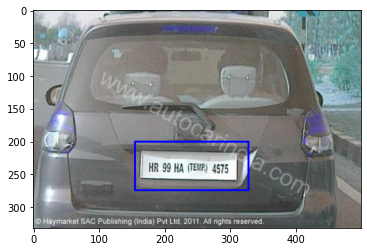

In [ ]:
image = plt.imread('rectangle.png')
plt.imshow(image)
plt.show()

# Serialize the dataframes

In [ ]:
train_labels.to_csv('train_labels.csv', index=False)
test_labels.to_csv('test_labels.csv', index=False)